# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:

# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [03:52<00:00, 1564.75it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [ ]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# [5] Assignment 4: Apply Naive Bayes

# Applying Multinomial Naive Bayes

In [51]:
# Adding prerocessed reviews to a new column
final['cleaned_text']=preprocessed_reviews
# considering balanced data for applying NB
final.sort_values(by='Time')
final1 = final.sample(n = 100000)

Y = final1['Score'].values
X = final1['cleaned_text'].values
print(Y.shape)
print(type(Y))
print(X.shape)
print(type(X))

(100000,)
<class 'numpy.ndarray'>
(100000,)
<class 'numpy.ndarray'>


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=12,shuffle=False)
X_train,X_cv,Y_train,Y_cv=train_test_split(X,Y,test_size=0.2,random_state=12,shuffle=False)
print('='*100)
print("After splitting")
print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

After splitting
(80000,) (80000,)
(20000,) (20000,)
(20000,) (20000,)


## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [53]:
vectorizer=CountVectorizer()
vectorizer=vectorizer.fit(X_train)
X_train_bow=vectorizer.transform(X_train)
X_cv_bow=vectorizer.transform(X_cv)
X_test_bow=vectorizer.transform(X_test)
print('='*100)
print("After transform")
print(X_train_bow.shape,Y_train.shape)
print(X_cv_bow.shape,Y_cv.shape)
print(X_test_bow.shape,Y_cv.shape)

After transform
(80000, 54408) (80000,)
(20000, 54408) (20000,)
(20000, 54408) (20000,)


In [54]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

100%|██████████| 9/9 [00:01<00:00,  6.81it/s]


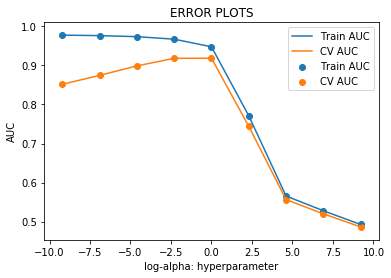

In [55]:
import math
logalpha=[]
train_auc = []
cv_auc = []
alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
for i in tqdm(alpha):
    naive = MultinomialNB(alpha=i, class_prior=None, fit_prior=True)
    naive.fit(X_train_bow, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  naive.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  naive.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logalpha.append(math.log(i))

plt.plot(logalpha, train_auc, label='Train AUC')
plt.scatter(logalpha, train_auc, label='Train AUC')
plt.plot(logalpha, cv_auc, label='CV AUC')
plt.scatter(logalpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log-alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

<b> Observation:</b> Since the gap between Train and Test ROC Curve is least at around between 0 & 10, We can apply crossvalidation at this small range.

In [56]:
cv_score = []
alpha=[0.001,0.01,0.05,0.1,0.5,1,1.5]
for k in tqdm(alpha):
    NB = MultinomialNB(alpha=k, class_prior=None, fit_prior=True)
    scores = cross_val_score(NB, X_train_bow, Y_train, cv=10, scoring='roc_auc')
    cv_score.append(scores.mean())

100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


_____________________________________________________________________________________________________
Optimal number alpha:  0.5
_____________________________________________________________________________________________________


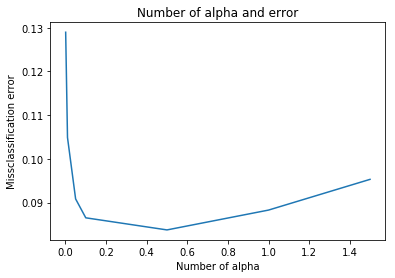

In [57]:
MSE = [1 - x for x in cv_score]
optimal_alpha = alpha[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number alpha: ", optimal_alpha)
print("_" * 101)


plt.plot(alpha, MSE)
plt.title("Number of alpha and error")
plt.xlabel("Number of alpha")
plt.ylabel("Missclassification error")
plt.show()

In [58]:
optimal_model = MultinomialNB(alpha=optimal_alpha)
optimal_model.fit(X_train_bow, Y_train)
prediction = optimal_model.predict(X_test_bow)

Plotting the AUC curve:

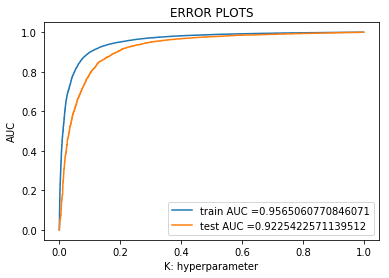

In [59]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_bow)[:,1])
AUC1=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Confusion Matrix for Train Data

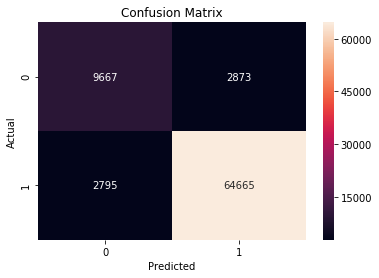

_____________________________________________________________________________________________________


In [60]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_train, optimal_model.predict(X_train_bow))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Confusion Matrix for Test Data

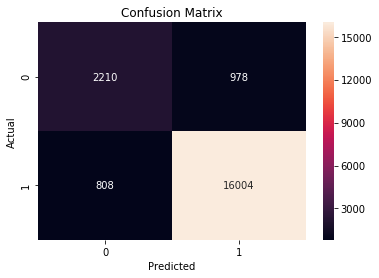

_____________________________________________________________________________________________________


In [61]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(X_test_bow))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Classification report

In [62]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      3188
           1       0.94      0.95      0.95     16812

   micro avg       0.91      0.91      0.91     20000
   macro avg       0.84      0.82      0.83     20000
weighted avg       0.91      0.91      0.91     20000



<b>Obervation:</b> AUC is 0.92. Which is good but lets try other methods as well.

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [63]:
#Storing all the feature names from CountVectorizerin a new list
feature_names=vectorizer.get_feature_names()
print(feature_names[:5])

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa']


In [64]:
#Storing all the log probabilities of features in a new variable
feature_log_prob=(optimal_model.feature_log_prob_)[:]
#Creating a new DataFrame with Feature names and their log probabilities
prob=pd.DataFrame(feature_log_prob,columns=feature_names)
print(prob.shape)

(2, 54408)


In [65]:
print(prob.head(3))
prob1=prob.T

          aa        aaa       aaaa      aaaaa  aaaaaaaaaaaa   aaaaaaah  \
0 -13.935054 -13.935054 -13.935054 -13.935054    -13.935054 -13.935054   
1 -11.858144 -11.662399 -13.523152 -13.523152    -14.370450 -14.370450   

       aaaah  aaaannnnddd       aaah     aaahhh  ...   zweiback   zwieback  \
0 -13.935054   -13.935054 -12.836442 -13.935054  ... -13.935054 -13.935054   
1 -14.370450   -14.370450 -13.271837 -14.370450  ... -13.859624 -13.271837   

          zy  zylicious    zylitol    zylotol       zyme     zyrtec  \
0 -13.935054 -13.935054 -11.989144 -13.935054 -13.935054 -13.935054   
1 -14.370450 -14.370450 -13.271837 -13.859624 -14.370450 -13.523152   

         zzz  zzzzzzzzzzz  
0 -13.935054   -13.935054  
1 -14.370450   -14.370450  

[2 rows x 54408 columns]


In [66]:
print(prob1[1].sort_values(ascending=False)[:10])

not       -3.734907
like      -4.571415
good      -4.686176
great     -4.754711
one       -4.907873
taste     -4.979762
coffee    -5.080774
tea       -5.082007
product   -5.082870
love      -5.085713
Name: 1, dtype: float64


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [67]:
print(prob1[0].sort_values(ascending=False)[:10])

not       -3.309710
like      -4.463658
would     -4.714466
product   -4.722217
taste     -4.753010
one       -4.903242
good      -5.159659
no        -5.179947
flavor    -5.218190
coffee    -5.224105
Name: 0, dtype: float64


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [68]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tf_idf_vect.fit(X_train)
X_train_tfidf= tf_idf_vect.transform(X_train)
X_cv_tfidf=tf_idf_vect.transform(X_cv)
X_test_tfidf=tf_idf_vect.transform(X_test)

100%|██████████| 9/9 [00:01<00:00,  5.42it/s]


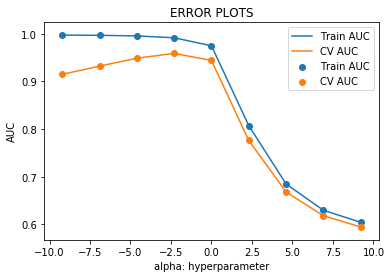

In [69]:
train_auc = []
cv_auc = []
logalpha1=[]
alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
for i in tqdm(alpha):
    naive = MultinomialNB(alpha=i, class_prior=None, fit_prior=True)
    naive.fit(X_train_tfidf, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  naive.predict_proba(X_train_tfidf)[:,1]
    Y_cv_pred =  naive.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logalpha1.append(math.log(i))
    
plt.plot(logalpha1, train_auc, label='Train AUC')
plt.scatter(logalpha1, train_auc, label='Train AUC')
plt.plot(logalpha1, cv_auc, label='CV AUC')
plt.scatter(logalpha1, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

<b> Observation:</b> Since the gap between Train and Test ROC Curve is least at around between 0 & 2.5, We can apply crossvalidation at this small range.

In [70]:
alpha=[0.001,0.01,0.05,0.1,0.5,1,1.5,2]
print("alpha=",alpha)
cv_score = []
for k in tqdm(alpha):
    NB = MultinomialNB(alpha=k, class_prior=None, fit_prior=True)
    scores = cross_val_score(NB, X_train_tfidf, Y_train, cv=10, scoring='roc_auc')
    cv_score.append(scores.mean())       

  0%|          | 0/8 [00:00<?, ?it/s]

alpha= [0.001, 0.01, 0.05, 0.1, 0.5, 1, 1.5, 2]


100%|██████████| 8/8 [00:12<00:00,  1.52s/it]


_____________________________________________________________________________________________________
Optimal number of neighbors:  0.1
_____________________________________________________________________________________________________
Missclassification error for each alpha  [0.077 0.056 0.046 0.044 0.048 0.059 0.075 0.092]
_____________________________________________________________________________________________________


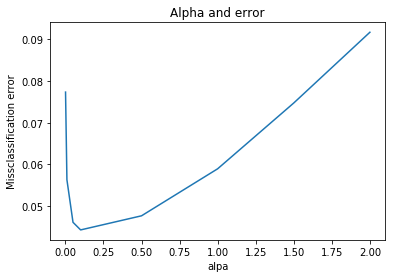

In [71]:
MSE = [1 - x for x in cv_score]
optimal_alpha2 = alpha[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number of neighbors: ", np.round(optimal_alpha2,2))
print("_" * 101)
print("Missclassification error for each alpha ", np.round(MSE, 3))
print("_" * 101)

plt.plot(alpha, MSE)
plt.title("Alpha and error")
plt.xlabel("alpa")
plt.ylabel("Missclassification error")
plt.show()

In [72]:
optimal_model = MultinomialNB(alpha=optimal_alpha2)
optimal_model.fit(X_train_tfidf, Y_train)
prediction = optimal_model.predict(X_test_tfidf)

Plotting the AUC Curve

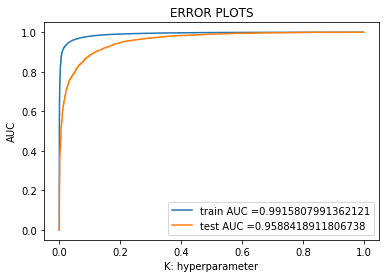

In [73]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_tfidf)[:,1])
AUC2=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Confusion Matrix for Train Data

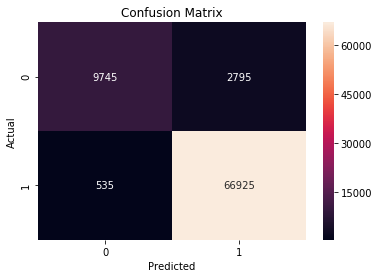

_____________________________________________________________________________________________________


In [74]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_train, optimal_model.predict(X_train_tfidf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Confusion Matrix for Test Data

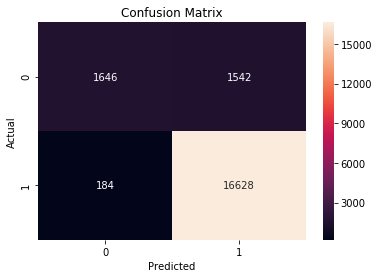

_____________________________________________________________________________________________________


In [75]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(X_test_tfidf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Classification Report

In [76]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.90      0.52      0.66      3188
           1       0.92      0.99      0.95     16812

   micro avg       0.91      0.91      0.91     20000
   macro avg       0.91      0.75      0.80     20000
weighted avg       0.91      0.91      0.90     20000



<b>Obervation:</b> AUC is 0.956. which is better than BOW Model.

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [77]:
feature_names=tf_idf_vect.get_feature_names()
print(feature_names[:5])

['aa', 'aaa', 'aaah', 'aafco', 'ab']


In [78]:

feature_log_prob=(optimal_model.feature_log_prob_)[:]
prob=pd.DataFrame(feature_log_prob,columns=feature_names)
print(prob.shape)

(2, 102553)


In [79]:
print(prob.head(3))
prob1=prob.T

          aa        aaa       aaah      aafco         ab      aback  \
0 -13.692087 -13.692087 -12.608377 -12.156002 -13.692087 -12.910929   
1 -11.691075 -11.917223 -13.499771 -13.270854 -12.323914 -12.729901   

     abandon  abandoned        abc  abdominal  ...       zone        zoo  \
0 -12.415851 -12.002872 -12.194939 -11.194859  ... -11.587040 -12.946100   
1 -12.262310 -12.460702 -12.986423 -12.957513  ... -11.612977 -11.653983   

   zoo animals       zotz   zucchini       zuke  zuke mini  zuke treats  \
0   -12.874470 -13.692087 -11.777541 -11.252830 -12.591254   -12.933523   
1   -13.705985 -12.065060 -11.293738 -10.902206 -12.634966   -12.524036   

       zukes    zylitol  
0 -12.074954 -11.692125  
1 -11.439836 -13.175479  

[2 rows x 102553 columns]


In [80]:
print(prob1[1].sort_values(ascending=False)[:10])

not       -5.494803
great     -5.845117
good      -5.914077
like      -5.976671
coffee    -6.052764
tea       -6.060471
love      -6.086624
product   -6.175034
taste     -6.208275
one       -6.209360
Name: 1, dtype: float64


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [81]:
print(prob1[0].sort_values(ascending=False)[:10])

not       -4.997153
like      -5.834773
product   -5.922079
taste     -5.960099
would     -5.969373
coffee    -6.211965
one       -6.217666
no        -6.346975
flavor    -6.392371
good      -6.472818
Name: 0, dtype: float64


### [5.3] Feature Engineered Model (Length of Reviews with BOW)

<li>Here as feature Engineering we will try to add the length of reviews as a feature with intention of increasing the AUC of the Model.</li>
<li>Due to memory Limitations, we will be considering 20K data points only.</li>

In [24]:
# Creating a list af length of words in preprocessed reviews
lengths=[]
for sentence in preprocessed_reviews:
    lengths.append(len(sentence.split()))
print(lengths[:5])
lengths1=np.asarray(lengths)
print(type(lengths1))
print(lengths1.shape)

[35, 27, 15, 53, 38]
<class 'numpy.ndarray'>
(364171,)


In [27]:
final['lengths']=lengths1
final2 = final.sample(n = 15000)

Y = final2['Score'].values
X = final2['cleaned_text'].values
Z = final2['lengths'].values
print(Y.shape)
print(type(Y))
print(X.shape)
print(type(X))

(15000,)
<class 'numpy.ndarray'>
(15000,)
<class 'numpy.ndarray'>


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=12,shuffle=False)
X_train,X_cv,Y_train,Y_cv=train_test_split(X,Y,test_size=0.2,random_state=12,shuffle=False)
print('='*100)
print("After splitting")
print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

After splitting
(12000,) (12000,)
(3000,) (3000,)
(3000,) (3000,)


In [29]:
Z_train,Z_test,S_train,S_test=train_test_split(Z,Y,test_size=0.2,random_state=12,shuffle=False)
Z_train,Z_cv,S_train,S_cv=train_test_split(Z,Y,test_size=0.2,random_state=12,shuffle=False)

In [30]:
print(Z_train.shape)
print(type(Z_train))

(12000,)
<class 'numpy.ndarray'>


In [31]:
vectorizer=CountVectorizer()
vectorizer=vectorizer.fit(X_train)
X_train_bow=vectorizer.transform(X_train)
X_cv_bow=vectorizer.transform(X_cv)
X_test_bow=vectorizer.transform(X_test)
print('='*100)
print("After transform")
print(X_train_bow.shape,Y_train.shape)
print(X_cv_bow.shape,Y_cv.shape)
print(X_test_bow.shape,Y_cv.shape)

After transform
(12000, 21929) (12000,)
(3000, 21929) (3000,)
(3000, 21929) (3000,)


In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [33]:
#For Train
from scipy import sparse
Z_train1=sparse.csr_matrix(Z_train)
print("X_train_bow:",X_train_bow.shape,type(X_train_bow))
print("Z_train1:",Z_train1.shape,type(Z_train1))

X_train_bow: (12000, 21929) <class 'scipy.sparse.csr.csr_matrix'>
Z_train1: (1, 12000) <class 'scipy.sparse.csr.csr_matrix'>


In [34]:
from scipy.sparse import hstack
train=hstack([X_train_bow,Z_train1.T]).toarray()

In [35]:
# For cv
from scipy import sparse
Z_cv1=sparse.csr_matrix(Z_cv)
print("X_cv_bow:",X_cv_bow.shape,type(X_cv_bow))
print("Z_cv1:",Z_cv1.shape,type(Z_cv1))

X_cv_bow: (3000, 21929) <class 'scipy.sparse.csr.csr_matrix'>
Z_cv1: (1, 3000) <class 'scipy.sparse.csr.csr_matrix'>


In [36]:
from scipy.sparse import hstack
cv=hstack([X_cv_bow,Z_cv1.T]).toarray()

In [37]:
# For Test
from scipy import sparse
Z_test1=sparse.csr_matrix(Z_test)
print("X_test_bow:",X_test_bow.shape,type(X_test_bow))
print("Z_test1:",Z_test1.shape,type(Z_test1))

X_test_bow: (3000, 21929) <class 'scipy.sparse.csr.csr_matrix'>
Z_test1: (1, 3000) <class 'scipy.sparse.csr.csr_matrix'>


In [38]:
from scipy.sparse import coo_matrix, hstack
test=hstack([X_test_bow,Z_test1.T]).toarray()

100%|██████████| 9/9 [00:44<00:00,  4.98s/it]


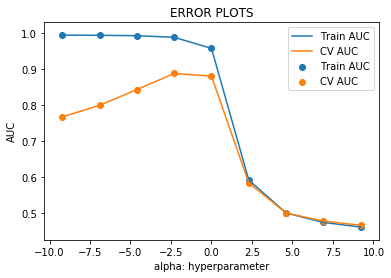

In [41]:
import math
train_auc = []
cv_auc = []
logalpha2=[]
alpha = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
for i in tqdm(alpha):
    naive = MultinomialNB(alpha=i, class_prior=None, fit_prior=True)
    naive.fit(train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  naive.predict_proba(train)[:,1]
    Y_cv_pred =  naive.predict_proba(cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
    logalpha2.append(math.log(i))

plt.plot(logalpha2, train_auc, label='Train AUC')
plt.scatter(logalpha2, train_auc, label='Train AUC')
plt.plot(logalpha2, cv_auc, label='CV AUC')
plt.scatter(logalpha2, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

<b> Observation:</b> Since the gap between Train and Test ROC Curve is least at around between 0 & 2.5, We can apply crossvalidation at this small range.

In [42]:
cv_score = []
alpha = np.arange(0, 2.5, 0.5)
for k in tqdm(alpha):
    NB = MultinomialNB(alpha=k, class_prior=None, fit_prior=True)
    scores = cross_val_score(NB, train, Y_train, cv=7, scoring='roc_auc')
    cv_score.append(scores.mean())                             

100%|██████████| 5/5 [02:08<00:00, 25.73s/it]


_____________________________________________________________________________________________________
Optimal number alpha:  0.5
_____________________________________________________________________________________________________


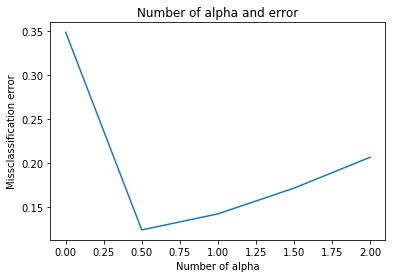

In [43]:
MSE = [1 - x for x in cv_score]
optimal_alpha3 = alpha[MSE.index(min(MSE))]
print("_" * 101)
print("Optimal number alpha: ", optimal_alpha3)
print("_" * 101)

plt.plot(alpha, MSE)
plt.title("Number of alpha and error")
plt.xlabel("Number of alpha")
plt.ylabel("Missclassification error")
plt.show()

In [45]:
optimal_model = MultinomialNB(alpha=optimal_alpha3)
optimal_model.fit(train, Y_train)
prediction = optimal_model.predict(test)

Plotting the ROC curve

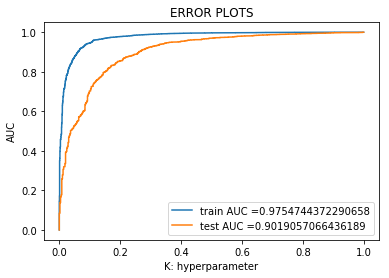

In [46]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(test)[:,1])
AUC3=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Confusion Matrix for Train Data

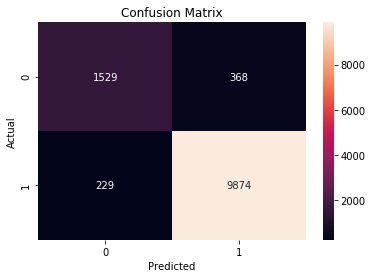

_____________________________________________________________________________________________________


In [47]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_train, optimal_model.predict(train))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Confusion Matrix for Test Data

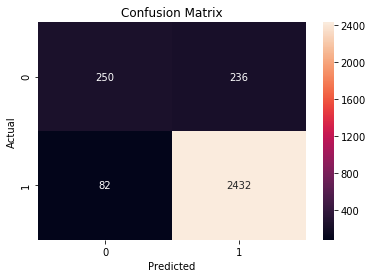

_____________________________________________________________________________________________________


In [48]:
import seaborn as sb
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(test))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

Classification Report:

In [49]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.75      0.51      0.61       486
           1       0.91      0.97      0.94      2514

   micro avg       0.89      0.89      0.89      3000
   macro avg       0.83      0.74      0.77      3000
weighted avg       0.89      0.89      0.89      3000



<b>Obervation:</b> AUC is 0.899. Which is good but is a little bit less as compared to TFIDF brute Model.

# [6] Conclusions

In [82]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
comparison = PrettyTable()
comparison.field_names = ["Vectorizer", "Model", "Hyperparameter(C)","Hyperparameter(alpha)", "AUC"]
comparison.add_row(["BOW", 'brute', optimal_alpha,(1/optimal_alpha), np.round(float(AUC1),3)])
comparison.add_row(["TFIDF", 'brute', optimal_alpha2,(1/optimal_alpha2), np.round(float(AUC2),3)])
comparison.add_row(["BOW(with length of reviews)", 'brute', optimal_alpha3,(1/optimal_alpha3), np.round(float(AUC3),3)])
print(comparison)

+-----------------------------+-------+-------------------+-----------------------+-------+
|          Vectorizer         | Model | Hyperparameter(C) | Hyperparameter(alpha) |  AUC  |
+-----------------------------+-------+-------------------+-----------------------+-------+
|             BOW             | brute |        0.5        |          2.0          | 0.923 |
|            TFIDF            | brute |        0.1        |          10.0         | 0.959 |
| BOW(with length of reviews) | brute |        0.5        |          2.0          | 0.902 |
+-----------------------------+-------+-------------------+-----------------------+-------+


<b><li>[1]. With reference to the Comparison Report above, NaiveBayes(with alpha=1) by using TFIDF with brute force model followed by NaiveBayes(with alpha=0.5) by using BOW with brute force model provides the best AUC and thus best performance. </li>
   <li>[2]. The Optimal Alpha is to be chosen such that our model is not Overfit or Underfit. This can be done by simply following the below methods:</li>
    <li>-(i).  Split the dataset into TRAIN-CV-TEST with an appropriate ratio like 0.6:0.2:0.2</li>
    <li>-(ii). Plot the ROC_AUC curve of both, Train and CV data.</li>
    <li>-(iii).Now choose the a short range for alpha such that the AUC of CV curve should be large and at the same time, should be closest to the TRAIN curve.</li>
    <li>-(iv). Now Apply cross_val_score to the selected range and from it, the optimal alpha can be calculated ny using the minimum Misclassification error function.</li> 
   <li>[4]. The Feature Engineered Model in which we added a feature of lengths of reviews, but did not get better performence as compared to TFIDF. This means that the length of reviews is not an important feature to be considered while building a NB model.</b>
    